In [13]:
pwd

'/data2/mito_lineage/Analysis/multiplex/data/vireo/pseudo/numC1000_ispropFalse'

In [3]:
AD_F = "cellSNP.tag.AD.mtx"
DP_F = "cellSNP.tag.DP.mtx"
VCF_F = "cellSNP.base.vcf"
INDIR='.'
OUTDIR='./results/'
NUM_DONORS=2
prob_threshold=0.8
indirs = ("data/PBMC_J_cellSNP", "data/PBMC_P_cellSNP")

In [4]:
import os
import pandas as pd
import seaborn as sns
from glob import glob
from scipy import stats
from os.path import join
import numpy as np

In [5]:
if not os.path.exists(OUTDIR):
    os.mkdir(OUTDIR)

In [6]:

in_cell_f = glob(join(INDIR,"cell_indices_*.txt"))
in_cell_names = []
cell_map = {}
for curr_cell_f in in_cell_f:
    print(curr_cell_f)
    with open(curr_cell_f, "r") as f:
        count = 0
        lines = []
        for line in f: 
            if count == 0:
                curr_f = line.strip()
            else:
                lines.append(line.strip().split(','))
            count += 1
    curr_df = pd.DataFrame(lines[1:], columns=lines[0])
    cell_map[curr_f] = curr_df["new index"].astype(int).values
    in_cell_names.append(curr_f)

./cell_indices_0.txt
./cell_indices_1.txt


In [7]:
cell_map[curr_f]

array([ 759,  760,  761,  762,  763,  764,  765,  766,  767,  768,  769,
        770,  771,  772,  773,  774,  775,  776,  777,  778,  779,  780,
        781,  782,  783,  784,  785,  786,  787,  788,  789,  790,  791,
        792,  793,  794,  795,  796,  797,  798,  799,  800,  801,  802,
        803,  804,  805,  806,  807,  808,  809,  810,  811,  812,  813,
        814,  815,  816,  817,  818,  819,  820,  821,  822,  823,  824,
        825,  826,  827,  828,  829,  830,  831,  832,  833,  834,  835,
        836,  837,  838,  839,  840,  841,  842,  843,  844,  845,  846,
        847,  848,  849,  850,  851,  852,  853,  854,  855,  856,  857,
        858,  859,  860,  861,  862,  863,  864,  865,  866,  867,  868,
        869,  870,  871,  872,  873,  874,  875,  876,  877,  878,  879,
        880,  881,  882,  883,  884,  885,  886,  887,  888,  889,  890,
        891,  892,  893,  894,  895,  896,  897,  898,  899,  900,  901,
        902,  903,  904,  905,  906,  907,  908,  9

In [8]:
in_cell_names

['data/PBMC_J_cellSNP', 'data/PBMC_P_cellSNP']

# Examples of using vireoSNP for donor deconvolution

In [9]:
import vireoSNP
import numpy as np
from scipy import sparse
from scipy.io import mmread

## Load cellSNP data 

##### Option 1 - VCF format

In [10]:
# cell_vcf = vireoSNP.load_VCF(VCF_F, biallelic_only=True)
# cell_dat = vireoSNP.vcf.read_sparse_GeneINFO(cell_vcf['GenoINFO'], keys=['AD', 'DP'])

# AD = cell_dat['AD']
# DP = cell_dat['DP']

##### Option 2 - sparse matrices

In [11]:
AD = mmread(AD_F).tocsc()
DP = mmread(DP_F).tocsc()
vcf = pd.read_csv(VCF_F, sep='\t')

In [12]:
vcf.head()

,#CHROM,POS,ID_x,REF_x,ALT,QUAL_x,FILTER_x,INFO_x,old data/PBMC_J_cellSNP,ID_y,REF_y,QUAL_y,FILTER_y,INFO_y,old data/PBMC_P_cellSNP,new ID
0,chr1,2290818,.,G,C,.,PASS,AD=34;DP=34;OTH=2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1
1,chr1,3624769,.,C,T,.,PASS,AD=0;DP=23;OTH=1,2.0,NaN,NaN,NaN,NaN,NaN,NaN,2
2,chr1,16237293,.,G,T,.,PASS,AD=1;DP=1;OTH=19,3.0,NaN,NaN,NaN,NaN,NaN,NaN,3
3,chr1,16904143,.,A,C,.,PASS,AD=1;DP=1;OTH=29,4.0,NaN,NaN,NaN,NaN,NaN,NaN,4
4,chr1,21294734,.,G,A,.,PASS,AD=0;DP=90;OTH=1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,5


Note, `AD` and `DP` are sparse matrices, not `numpy.array`

## Run Vireo
For donor deconvolution, the `vireoSNP.vireo_wrap` function can be directly used, which contains multiple initialization and have options for different situtaions of donor genotype, fully missing, partially lack, or all available.

In [11]:
res = vireoSNP.vireo_wrap(AD, DP, n_donor=NUM_DONORS, learn_GT=True,
                          n_extra_donor=0, ASE_mode=False, fix_beta_sum=False,
                          n_init=50, check_doublet=True, random_seed=1)

[vireo] lower bound ranges [-1497.7, -1431.9, -1299.9]
[vireo] allelic rate mean and concentrations:
[[0.005 0.468 0.995]]
[[23957.3  3990.4 24472.3]]
[vireo] donor size before removing doublets:
donor0	donor1
657	764


In [12]:
res.keys()

dict_keys(['ID_prob', 'GT_prob', 'doublet_prob', 'theta_shapes', 'theta_mean', 'theta_sum', 'LB_list', 'LB_doublet'])

##### The donor assignment probability

In [13]:
res["ID_prob"].shape

(1421, 2)

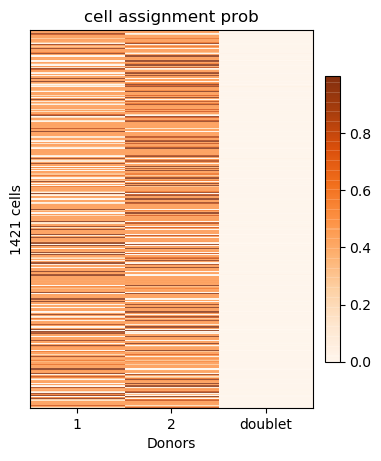

In [14]:
import matplotlib.pyplot as plt
from vireoSNP.plot.base_plot import heat_matrix

fig = plt.figure(figsize=(4, 5), dpi=100)
# assign_prob_comb = res['ID_prob']
assign_prob_comb = np.append(res['ID_prob'], 
                             np.sum(res['doublet_prob'], axis=1, 
                                    keepdims=True), axis=1)
im = heat_matrix(assign_prob_comb,
                 cmap="Oranges", alpha=0.8,
                 display_value=False, row_sort=False)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("cell assignment prob")
plt.xlabel("Donors")
plt.ylabel("%d cells" %(res['ID_prob'].shape[0]))
plt.yticks([])
plt.xticks(np.arange(NUM_DONORS+1), np.append(np.arange(NUM_DONORS)+1,"doublet"))

# plt.tight_layout()
plt.show()

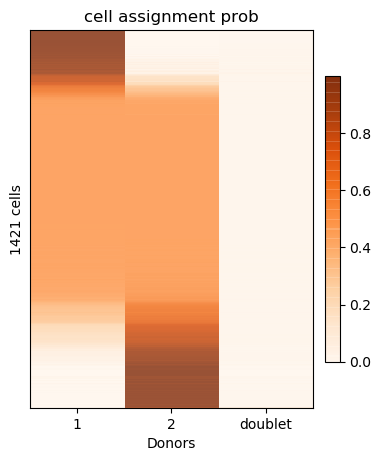

In [15]:
import matplotlib.pyplot as plt
from vireoSNP.plot.base_plot import heat_matrix

fig = plt.figure(figsize=(4, 5), dpi=100)
# assign_prob_comb = res['ID_prob']
assign_prob_comb = np.append(res['ID_prob'], 
                             np.sum(res['doublet_prob'], axis=1, 
                                    keepdims=True), axis=1)
im = heat_matrix(assign_prob_comb,
                 cmap="Oranges", alpha=0.8,
                 display_value=False, row_sort=True)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("cell assignment prob")
plt.xlabel("Donors")
plt.ylabel("%d cells" %(res['ID_prob'].shape[0]))
plt.yticks([])
plt.xticks(np.arange(NUM_DONORS+1), np.append(np.arange(NUM_DONORS)+1,"doublet"))

# plt.tight_layout()
plt.show()

In [16]:
res["ID_prob"].shape

(1421, 2)

In [17]:
AD_dense = AD.todense()
(AD_dense > 0).sum(axis=1).shape

(1878, 1)

In [18]:
AD_dense = AD.todense()
(AD_dense > 0).sum(axis=0).shape

(1, 1421)

In [19]:
AD_dense.shape

(1878, 1421)

## Compare cell IDs to known values

In [20]:
## donor id with highest probability
donor_ids_best = np.argmax(res['ID_prob'], axis=1)

In [21]:
cell_map

{'data/PBMC_J_cellSNP': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
         27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
         40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
         53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
         66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
         79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
        105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
        118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
        131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
        144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
        157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 

In [22]:
in_cell_names

['data/PBMC_J_cellSNP', 'data/PBMC_P_cellSNP']

In [23]:
max_v = 0
for i in in_cell_names:
    max_v = max(max_v, max(cell_map[i]))
    
# create index map:
cell_ind_map = {}
count = 0
for i in in_cell_names: 
    cell_ind_map[i] = count
    count += 1

cell_inds = -1*np.ones(max_v)
for i in in_cell_names:
    cell_inds[cell_map[i]-1] = cell_ind_map[i] #cell_map[i]
cell_inds

array([0., 0., 0., ..., 1., 1., 1.])

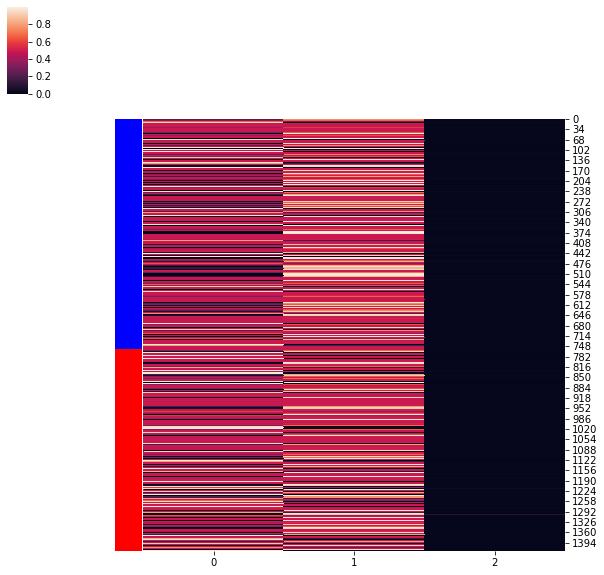

In [24]:
colors = {0:"blue", 1:"red"}
cell_colors = [colors[x] for x in cell_inds]

sns.clustermap(data=assign_prob_comb, row_cluster=False, col_cluster=False,
              row_colors=cell_colors)

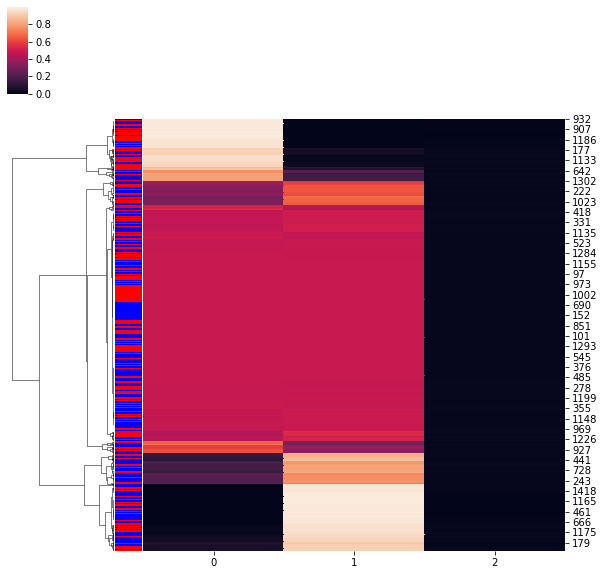

In [25]:
colors = {0:"blue", 1:"red"}
cell_colors = [colors[x] for x in cell_inds]

sns.clustermap(data=assign_prob_comb, row_cluster=True, col_cluster=False,
              row_colors=cell_colors)

In [26]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(cell_inds, donor_ids_best).ravel()
(tn, fp, fn, tp)

(217, 541, 317, 346)

### Assignment probability threshold

In [27]:
## doublet rate

doublet_threshold = 0.9
is_doublet = np.sum(res['doublet_prob'], axis=1) > doublet_threshold
print("%d cells are called doublet" %(sum(is_doublet)))

prob_threshold = prob_threshold #0.9
is_unassigned = (np.max(res['ID_prob'], axis=1) < prob_threshold) & (~is_doublet)
print("%d cells are unassigned to singlet or doublets" %(sum(is_unassigned)))

0 cells are called doublet
960 cells are unassigned to singlet or doublets


### Allelic ratio per variant per donor

In [28]:
## If ASE_mode is False
AF_SNPs = np.tensordot(res['GT_prob'], res['theta_mean'][0, :], axes=[2, 0])

## Get the top averaged SNP AF , print out the AD counts in each sample and get the vcf

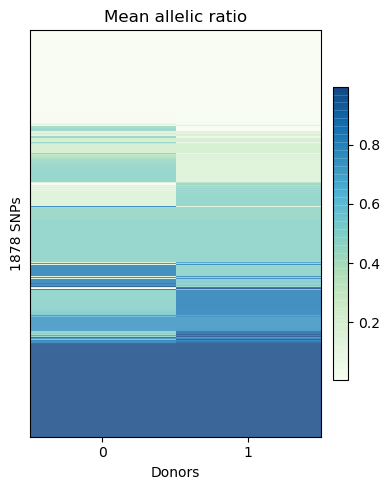

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
from vireoSNP.plot.base_plot import heat_matrix

fig = plt.figure(figsize=(4, 5), dpi=100)
im = heat_matrix(AF_SNPs, cmap="GnBu", alpha=0.8,
                 display_value=False, row_sort=True)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Mean allelic ratio")
plt.xlabel("Donors")
plt.ylabel("%d SNPs" %(AF_SNPs.shape[0]))
plt.yticks([])
plt.xticks(np.arange(AF_SNPs.shape[1]))

plt.tight_layout()
#plt.show()

In [30]:
for ind, val in enumerate(in_cell_names):
    vcf["AF " + str(ind)] = AF_SNPs[:, ind]
#vcf.iloc[ind.argsort()[::-1]].head(100)
vcf.iloc[vcf["AF " + str(ind)].argsort()[::-1].values]

,#CHROM,POS,ID_x,REF_x,ALT,QUAL_x,FILTER_x,INFO_x,old data/PBMC_J_cellSNP,ID_y,REF_y,QUAL_y,FILTER_y,INFO_y,old data/PBMC_P_cellSNP,new ID,AF 0,AF 1
796,chr16,10744182,.,C,T,.,PASS,AD=107;DP=107;OTH=2,797.0,NaN,NaN,NaN,NaN,NaN,NaN,797,0.994589,0.994589
1481,chr9,85742147,NaN,NaN,C,NaN,NaN,NaN,NaN,.,G,.,PASS,AD=86;DP=98;OTH=0,501.0,1482,0.468103,0.994589
1006,chr19,53867486,.,C,T,.,PASS,AD=62;DP=64;OTH=0,1007.0,.,C,.,PASS,AD=63;DP=64;OTH=0,935.0,1007,0.994589,0.994589
402,chr6,159762417,.,T,G,.,PASS,AD=123;DP=123;OTH=3,403.0,NaN,NaN,NaN,NaN,NaN,NaN,403,0.994589,0.994589
119,chr2,113890000,.,C,T,.,PASS,AD=98;DP=98;OTH=1,120.0,NaN,NaN,NaN,NaN,NaN,NaN,120,0.994589,0.994589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388,chr6,131199894,.,C,T,.,PASS,AD=0;DP=55;OTH=1,389.0,.,C,.,PASS,AD=0;DP=82;OTH=1,389.0,389,0.005142,0.005142
523,chr9,83921549,.,G,A,.,PASS,AD=0;DP=67;OTH=1,524.0,.,G,.,PASS,AD=0;DP=90;OTH=1,499.0,524,0.005142,0.005142
840,chr17,7615037,.,G,A,.,PASS,AD=0;DP=146;OTH=2,841.0,.,G,.,PASS,AD=0;DP=99;OTH=1,798.0,841,0.005142,0.005142
830,chr16,89874292,.,A,G,.,PASS,AD=0;DP=88;OTH=1,831.0,.,A,.,PASS,AD=1;DP=89;OTH=0,786.0,831,0.005142,0.005142


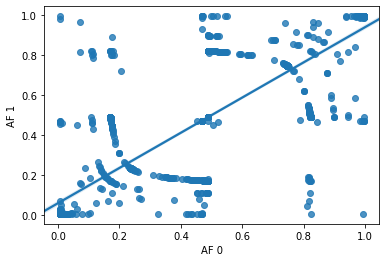

In [31]:
sns.regplot(data=vcf, x ="AF 0" , y="AF 1")

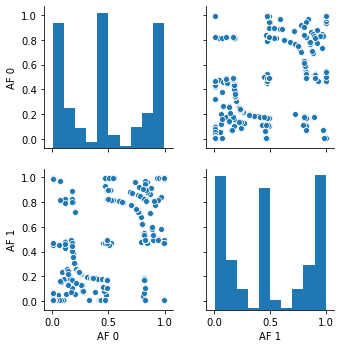

In [32]:
sns.pairplot(data=vcf, vars=["AF 0", "AF 1"])

<Figure size 3000x3000 with 0 Axes>

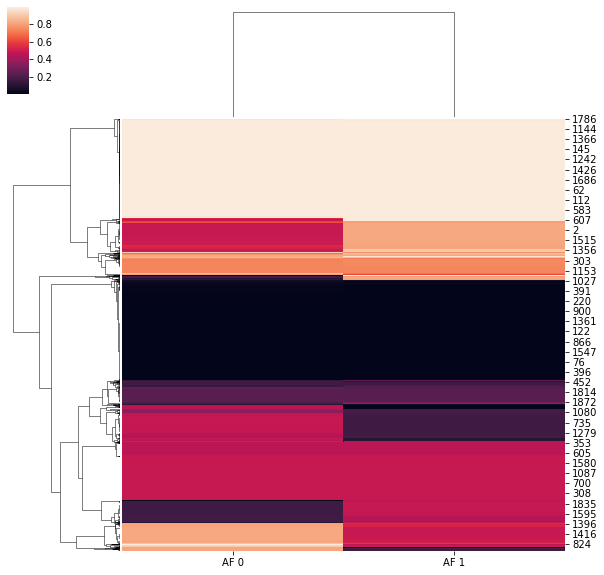

In [33]:
f = plt.figure(figsize=(10,10), dpi=300)
sns.clustermap(data=vcf[["AF 0" , "AF 1"]])

In [34]:
dense_ad = pd.DataFrame(AD.todense())
(dense_ad>0).sum().sum()

dense_dp = pd.DataFrame(DP.todense())
(dense_dp>0).sum().sum()

32313

In [35]:
print(f"Number of same exact allele freq: {(vcf['old data/PBMC_J_cellSNP']==vcf['old data/PBMC_P_cellSNP']).sum()}")

Number of same exact allele freq: 6


In [36]:
print(f"Number of variants with 99.5% AF: {len(AF_SNPs[(np.absolute(AF_SNPs[:,0]-0.99518961))<0.01])}")

Number of variants with 99.5% AF: 427


In [37]:
vcf

,#CHROM,POS,ID_x,REF_x,ALT,QUAL_x,FILTER_x,INFO_x,old data/PBMC_J_cellSNP,ID_y,REF_y,QUAL_y,FILTER_y,INFO_y,old data/PBMC_P_cellSNP,new ID,AF 0,AF 1
0,chr1,2290818,.,G,C,.,PASS,AD=34;DP=34;OTH=2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1,0.994519,0.994588
1,chr1,3624769,.,C,T,.,PASS,AD=0;DP=23;OTH=1,2.0,NaN,NaN,NaN,NaN,NaN,NaN,2,0.005877,0.005334
2,chr1,16237293,.,G,T,.,PASS,AD=1;DP=1;OTH=19,3.0,NaN,NaN,NaN,NaN,NaN,NaN,3,0.489280,0.823032
3,chr1,16904143,.,A,C,.,PASS,AD=1;DP=1;OTH=29,4.0,NaN,NaN,NaN,NaN,NaN,NaN,4,0.489534,0.822543
4,chr1,21294734,.,G,A,.,PASS,AD=0;DP=90;OTH=1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,5,0.005142,0.005142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1873,chrX,129906125,NaN,NaN,C,NaN,NaN,NaN,NaN,.,T,.,PASS,AD=0;DP=1;OTH=60,998.0,1874,0.174965,0.447590
1874,chrX,135098900,NaN,NaN,A,NaN,NaN,NaN,NaN,.,G,.,PASS,AD=0;DP=83;OTH=1,999.0,1875,0.005142,0.005142
1875,chrX,149938651,NaN,NaN,G,NaN,NaN,NaN,NaN,.,C,.,PASS,AD=0;DP=70;OTH=1,1000.0,1876,0.005142,0.005142
1876,chrX,150898821,NaN,NaN,A,NaN,NaN,NaN,NaN,.,G,.,PASS,AD=0;DP=4;OTH=41,1002.0,1877,0.164153,0.070630


In [38]:
vcf[(vcf["AF 0"]>0.9) & (vcf["AF 1"]>0.9)]

,#CHROM,POS,ID_x,REF_x,ALT,QUAL_x,FILTER_x,INFO_x,old data/PBMC_J_cellSNP,ID_y,REF_y,QUAL_y,FILTER_y,INFO_y,old data/PBMC_P_cellSNP,new ID,AF 0,AF 1
0,chr1,2290818,.,G,C,.,PASS,AD=34;DP=34;OTH=2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1,0.994519,0.994588
7,chr1,24416958,.,G,A,.,PASS,AD=31;DP=32;OTH=0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,8,0.993572,0.994586
10,chr1,28648779,.,C,G,.,PASS,AD=60;DP=60;OTH=2,11.0,NaN,NaN,NaN,NaN,NaN,NaN,11,0.994589,0.994589
21,chr1,66336070,.,G,A,.,PASS,AD=73;DP=73;OTH=1,22.0,NaN,NaN,NaN,NaN,NaN,NaN,22,0.994589,0.994589
27,chr1,85062230,.,G,A,.,PASS,AD=81;DP=81;OTH=1,28.0,NaN,NaN,NaN,NaN,NaN,NaN,28,0.994589,0.994589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860,chrX,13653194,NaN,NaN,T,NaN,NaN,NaN,NaN,.,C,.,PASS,AD=39;DP=39;OTH=1,983.0,1861,0.994588,0.994588
1861,chrX,47233421,NaN,NaN,G,NaN,NaN,NaN,NaN,.,A,.,PASS,AD=71;DP=71;OTH=1,985.0,1862,0.994589,0.994589
1863,chrX,51893333,NaN,NaN,G,NaN,NaN,NaN,NaN,.,A,.,PASS,AD=20;DP=20;OTH=1,987.0,1864,0.991022,0.994562
1868,chrX,80809940,NaN,NaN,T,NaN,NaN,NaN,NaN,.,C,.,PASS,AD=98;DP=98;OTH=1,993.0,1869,0.994589,0.994589


In [39]:
vcf[(vcf["AF 0"]>0.95) & (vcf["AF 1"]>0.95)]

,#CHROM,POS,ID_x,REF_x,ALT,QUAL_x,FILTER_x,INFO_x,old data/PBMC_J_cellSNP,ID_y,REF_y,QUAL_y,FILTER_y,INFO_y,old data/PBMC_P_cellSNP,new ID,AF 0,AF 1
0,chr1,2290818,.,G,C,.,PASS,AD=34;DP=34;OTH=2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1,0.994519,0.994588
7,chr1,24416958,.,G,A,.,PASS,AD=31;DP=32;OTH=0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,8,0.993572,0.994586
10,chr1,28648779,.,C,G,.,PASS,AD=60;DP=60;OTH=2,11.0,NaN,NaN,NaN,NaN,NaN,NaN,11,0.994589,0.994589
21,chr1,66336070,.,G,A,.,PASS,AD=73;DP=73;OTH=1,22.0,NaN,NaN,NaN,NaN,NaN,NaN,22,0.994589,0.994589
27,chr1,85062230,.,G,A,.,PASS,AD=81;DP=81;OTH=1,28.0,NaN,NaN,NaN,NaN,NaN,NaN,28,0.994589,0.994589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860,chrX,13653194,NaN,NaN,T,NaN,NaN,NaN,NaN,.,C,.,PASS,AD=39;DP=39;OTH=1,983.0,1861,0.994588,0.994588
1861,chrX,47233421,NaN,NaN,G,NaN,NaN,NaN,NaN,.,A,.,PASS,AD=71;DP=71;OTH=1,985.0,1862,0.994589,0.994589
1863,chrX,51893333,NaN,NaN,G,NaN,NaN,NaN,NaN,.,A,.,PASS,AD=20;DP=20;OTH=1,987.0,1864,0.991022,0.994562
1868,chrX,80809940,NaN,NaN,T,NaN,NaN,NaN,NaN,.,C,.,PASS,AD=98;DP=98;OTH=1,993.0,1869,0.994589,0.994589


## Choose the number of donors

Unsually, the number of donors are known. In case you are not sure on this, you could try a set of numbers, e.g., from 2 to 6 here, and pick the one when the evidence lower bound (ELBO) stops increasing, e.g., 
[Figure 2A in Vireo paper](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1865-2/figures/2)

In this data set, `n_donor=4` is a sensible choice.

In [40]:
n_donor_list = np.arange(2, 7)
ELBO_list_all = []
for _n_don in n_donor_list:
    res = vireoSNP.vireo_wrap(AD, DP, n_donor=_n_don, learn_GT=True,
                              n_extra_donor=0, ASE_mode=False, fix_beta_sum=False,
                              n_init=50, check_doublet=True, random_seed=1)
    ELBO_list_all.append(res['LB_list'])

[vireo] lower bound ranges [-1497.7, -1431.9, -1299.9]
[vireo] allelic rate mean and concentrations:
[[0.005 0.468 0.995]]
[[23957.3  3990.4 24472.3]]
[vireo] donor size before removing doublets:
donor0	donor1
657	764
[vireo] lower bound ranges [-51.4, 121.0, 318.4]
[vireo] allelic rate mean and concentrations:
[[0.004 0.465 0.996]]
[[24030.9  3809.9 24579.2]]
[vireo] donor size before removing doublets:
donor0	donor1	donor2
433	529	460
[vireo] lower bound ranges [1168.7, 1486.4, 1679.4]
[vireo] allelic rate mean and concentrations:
[[0.003 0.453 0.996]]
[[24083.1  3632.4 24704.5]]
[vireo] donor size before removing doublets:
donor0	donor1	donor2	donor3
339	379	267	436
[vireo] lower bound ranges [1930.8, 2304.7, 2668.0]
[vireo] allelic rate mean and concentrations:
[[0.002 0.447 0.997]]
[[23905.4  3943.9 24570.8]]
[vireo] donor size before removing doublets:
donor0	donor1	donor2	donor3	donor4
292	370	331	115	312
[vireo] lower bound ranges [2324.1, 2985.4, 3237.3]
[vireo] allelic rate m

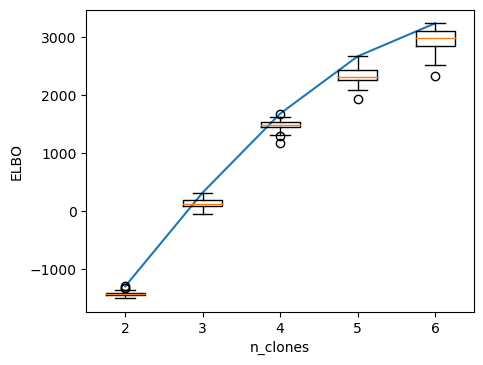

<Figure size 432x288 with 0 Axes>

In [41]:
import matplotlib.pyplot as plt
from vireoSNP.plot.base_plot import heat_matrix

fig = plt.figure(figsize=(5, 4), dpi=100)
plt.plot(n_donor_list - 1, np.max(ELBO_list_all, axis=1))
plt.boxplot(ELBO_list_all)
plt.xticks(n_donor_list - 1, n_donor_list)
plt.ylabel("ELBO")
plt.xlabel("n_clones")
plt.show()

plt.savefig(join(OUTDIR, "number_of_donors_ELBO.png"))